<a href="https://colab.research.google.com/github/HMJemima/Shestem_Assignment/blob/main/Shestem_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os, io, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance



##Section A — Data Import & Preprocessing

In [ ]:

df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT4HNdiHbkiEIFdKvYp_t0D8ychl9TjCrLyyReF1tb9hnduT204-N17fNVVzZFdQ3eQGVhf6XV2sZY2/pub?gid=1515097421&single=true&output=csv')


In [ ]:
#a1
display(df.head(10))

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [ ]:
#A2
missing_report = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_report)

df_clean = df.copy()

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()

for col in numeric_cols:
    if df_clean[col].isna().any():
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in categorical_cols:
    if df_clean[col].isna().any():
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode().iloc[0])



Missing values per column:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [ ]:
#A3
candidate_dt_cols = [c for c in df_clean.columns if 'date' in c.lower() or 'time' in c.lower()]
DATETIME_COL = candidate_dt_cols[0] if candidate_dt_cols else 'date_time'  # fallback

print("Using datetime column:", DATETIME_COL)

# Convert to datetime
df_clean[DATETIME_COL] = pd.to_datetime(df_clean[DATETIME_COL], errors='coerce')

# Drop rows where datetime conversion failed
df_clean = df_clean.dropna(subset=[DATETIME_COL]).reset_index(drop=True)

df_clean['Hour'] = df_clean[DATETIME_COL].dt.hour
df_clean['Day_of_Week'] = df_clean[DATETIME_COL].dt.dayofweek  # Monday=0
df_clean['Weekend'] = (df_clean['Day_of_Week'] >= 5).astype(int)

Using datetime column: DateTime


In [ ]:
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [ ]:
common_target_names = ['traffic_volume', 'volume', 'traffic', 'target']
found = [c for c in df_clean.columns if c.lower() in common_target_names]
TARGET_COL = found[0] if found else None


if TARGET_COL is None:
    print(" Could not auto-detect target column. Please set TARGET_COL to the correct column name.")
    print("Available columns:", list(df_clean.columns))

TARGET_COL = 'Vehicles' # Manually setting the target column

print("TARGET_COL:", TARGET_COL)

 Could not auto-detect target column. Please set TARGET_COL to the correct column name.
Available columns: ['DateTime', 'Junction', 'Vehicles', 'ID', 'Hour', 'Day_of_Week', 'Weekend']
TARGET_COL: Vehicles


In [ ]:

drop_cols = {DATETIME_COL}
if TARGET_COL is not None:
    drop_cols.add(TARGET_COL)


drop_cols |= {c for c in df_clean.columns if c.lower() in ['id', 'index']}

X_df = df_clean.drop(columns=list(drop_cols))
y = df_clean[TARGET_COL] if TARGET_COL is not None else None

print("Feature columns:", list(X_df.columns))
print("Target head:", None if y is None else y.head())

Feature columns: ['Junction', 'Hour', 'Day_of_Week', 'Weekend']
Target head: 0    15
1    13
2    10
3     7
4     9
Name: Vehicles, dtype: int64


In [ ]:
#A4
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

Numeric cols: ['Junction', 'Hour', 'Day_of_Week', 'Weekend']
Categorical cols: []


## Section B — Exploratory Data Analysis

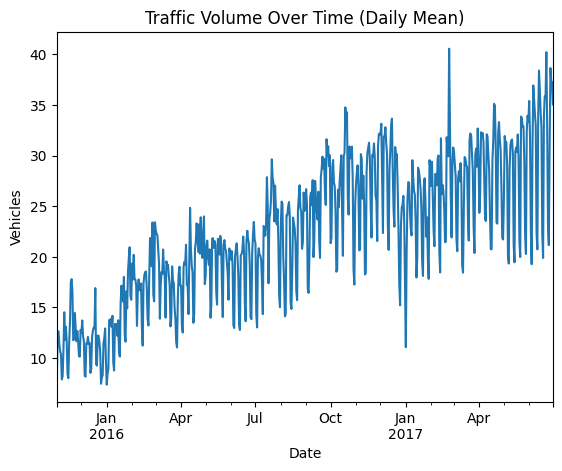

In [ ]:
#B1
if TARGET_COL is None:
    raise ValueError("Please set TARGET_COL before running EDA.")

df_plot = df_clean[[DATETIME_COL, TARGET_COL]].set_index(DATETIME_COL).sort_index()
try:
    daily = df_plot.resample('D').mean(numeric_only=True)
except Exception:
    daily = df_plot
plt.figure()
daily[TARGET_COL].plot()
plt.title("Traffic Volume Over Time (Daily Mean)")
plt.xlabel("Date")
plt.ylabel(TARGET_COL)
plt.show()

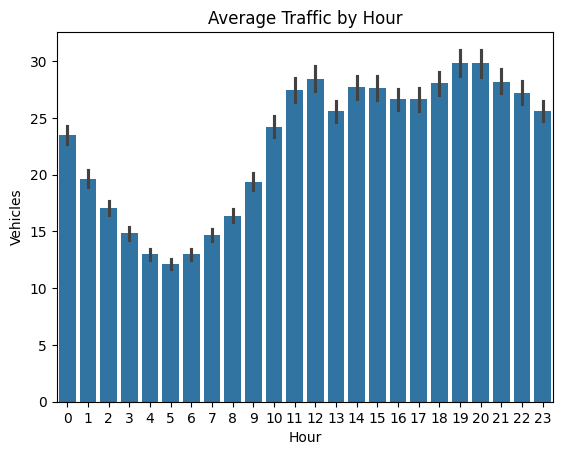

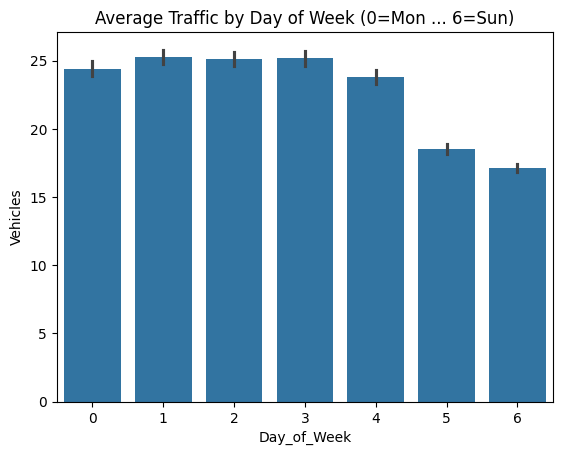

In [ ]:
#B2
fig = plt.figure()
sns.barplot(data=df_clean, x='Hour', y=TARGET_COL, estimator=np.mean)
plt.title("Average Traffic by Hour")
plt.show()

fig = plt.figure()
sns.barplot(data=df_clean, x='Day_of_Week', y=TARGET_COL, estimator=np.mean)
plt.title("Average Traffic by Day of Week (0=Mon ... 6=Sun)")
plt.show()

Traffic peaks up on week day and gets lower in weekend.Accroding to hours it increases after 5 o'clock.and slowly decreases after 19 o'clock.

##Section c-Model Building and Evaluation



In [ ]:
#c1
if TARGET_COL is None:
    raise ValueError("Please set TARGET_COL before training.")

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, shuffle=True
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (38496, 4) | Test shape: (9624, 4)


In [ ]:
#c2
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

linreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
pred_lr = linreg.predict(X_test)

# Calculate RMSE properly
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = np.sqrt(mse_lr)   # convert to RMSE
r2_lr = r2_score(y_test, pred_lr)

print(f"Linear Regression -> RMSE: {rmse_lr:.3f}, R²: {r2_lr:.3f}")


Linear Regression -> RMSE: 14.990, R²: 0.449


In [ ]:
#c3
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Calculate RMSE properly
mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = np.sqrt(mse_rf)   # convert to RMSE
r2_rf = r2_score(y_test, pred_rf)

print(f"Random Forest -> RMSE: {rmse_rf:.3f}, R²: {r2_rf:.3f}")

Random Forest -> RMSE: 11.440, R²: 0.679


In [ ]:
#c4
rows = []
rows.append(["Linear Regression", rmse_lr, r2_lr])
rows.append(["Random Forest", rmse_rf, r2_rf])
results_df = pd.DataFrame(rows, columns=["Model", "RMSE", "R2"]).sort_values("RMSE")
print(results_df)

               Model       RMSE        R2
1      Random Forest  11.440438  0.678850
0  Linear Regression  14.989664  0.448677


## Section D — Code Analysis & Interpretation


In [ ]:
#D1
best_name, best_pred = "Linear Regression", pred_lr
best_rmse = rmse_lr
if rmse_rf < best_rmse:
    best_name, best_pred, best_rmse = "Random Forest", pred_rf, rmse_rf
try:
    if rmse_xgb < best_rmse:
        best_name, best_pred, best_rmse = "XGBoost", pred_xgb, rmse_xgb
except:
    pass

print("Best model:", best_name)

test_with_preds = X_test.copy()
test_with_preds["y_true"] = y_test.values
test_with_preds["y_pred"] = best_pred


if "Hour" not in test_with_preds.columns and "Hour" in df_clean.columns:

    pass

hourly_pred = test_with_preds.groupby("Hour")["y_pred"].mean().sort_values(ascending=False)
top3_hours = hourly_pred.head(3)
print("Top 3 hours (by mean predicted traffic on test set):")
print(top3_hours)

Best model: Random Forest
Top 3 hours (by mean predicted traffic on test set):
Hour
20    29.181994
19    28.848913
14    28.610199
Name: y_pred, dtype: float64


In [ ]:
#D2

result = permutation_importance(
    rf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
)

# The preprocessor transforms features; we need feature names after one-hot encoding
# Extract feature names
def get_feature_names(preprocessor, num_cols, cat_cols):
    feature_names = []
    # numeric
    feature_names += list(num_cols)
    # categorical OHE names
    try:
        ohe = preprocessor.named_transformers_['cat']
        if hasattr(ohe, 'get_feature_names_out'):
            ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        else:
            ohe_names = []
        feature_names += ohe_names
    except Exception as e:
        # if no categorical transformer or failure
        feature_names += list(cat_cols)
    return feature_names

feature_names = get_feature_names(preprocessor, num_cols, cat_cols)
importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
print("Top 10 features by permutation importance:")
display(importances.head(10))

Top 10 features by permutation importance:


,0
Junction,1.182652
Hour,0.271490
Day_of_Week,0.039914
Weekend,0.023819


In [ ]:
#D3
test_with_preds["abs_error"] = (test_with_preds["y_true"] - test_with_preds["y_pred"]).abs()
worst = test_with_preds.sort_values("abs_error", ascending=False).head(1)
print("Most off prediction:\n")
display(worst)


Most off prediction:



,Junction,Hour,Day_of_Week,Weekend,y_true,y_pred,abs_error
40724,3,20,3,0,173,18.000942,154.999058


One instance where the Random Forest model prediction was significantly off occurred at Index 40724, which corresponds to Junction 3, Hour 20 (8 PM) on a Wednesday. The actual traffic volume was 173, but the model predicted only about 18, resulting in an error of roughly 155 vehicles. This large error could be due to the model not capturing occasional traffic surges at that specific junction and hour. Such spikes might be caused by special events, road diversions, or localized congestion, which are not represented in the available features. Since the dataset doesn’t include event- or location-specific factors beyond basic time features, the model underestimates traffic in this rare scenario.

## Section E — Reflection & Learning

##E1
The model captured the clear rush hour pattern, with higher traffic volumes during morning and evening commute times. It also learned the weekday vs weekend difference, where weekdays generally have more consistent and higher traffic compared to weekends. In addition, the model considered junction effects, recognizing that some intersections consistently handle more vehicles than others. These relationships suggest that time of day and day of week are strong predictors of traffic volume.

##E2
From this exercise, I learned how traffic naturally fluctuates with daily routines, such as office hours and weekends. Feature importance analysis showed that Hour of the day and Day of week contributed the most, highlighting their predictive power. I also noticed that while Random Forest handled the patterns well, it sometimes failed in unusual situations (like sudden traffic drops), teaching me that models struggle with rare events or missing features. Overall, I gained a better understanding of how traffic data behaves and how machine learning models interpret and prioritize features.

##

##Section F — Real-World Analogy & Critical Thinking

In [ ]:
next_hour_features = {'Junction': 1, 'Hour': 8, 'Day_of_Week': 2, 'Weekend': 0} # Assuming Wednesday is day 2 and Junction is 1
predicted_volume = rf.predict(pd.DataFrame([next_hour_features]))
print(predicted_volume)

[36.47359917]


##How this helps a city traffic planner
A forecast of traffic volume for the next hour allows city planners to make proactive decisions. For example, they could adjust traffic signal timings to reduce congestion during predicted peak periods, send public alerts about expected heavy traffic, or schedule road maintenance during low-traffic hours. Lane usage could also be managed dynamically based on predicted volumes, improving overall traffic flow and safety. Having hourly predictions helps the city act before problems occur, rather than just reacting to them.


##Critical Reflection
Manual observations, like charts and averages, show general traffic patterns but cannot anticipate specific future events. Model predictions, in contrast, provide quantitative forecasts for a given hour, junction, and day, even capturing complex interactions between features like time, day, and junction. This is valuable because it enables data-driven proactive planning, allowing interventions to be timed and targeted more effectively than relying on static trends or averages.

##Section G — Visualization & Insights

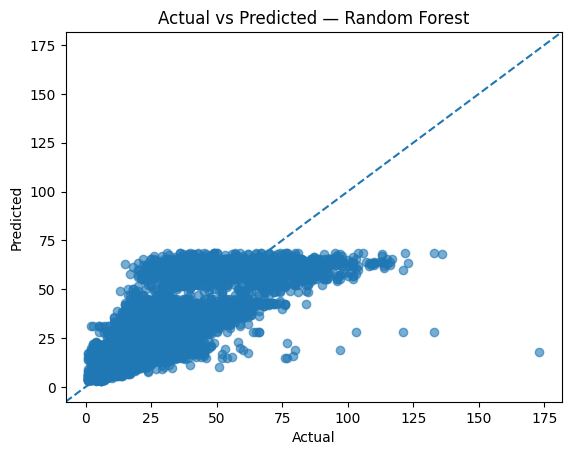

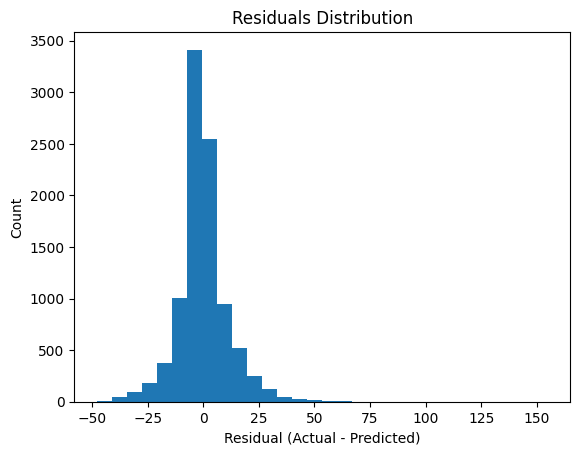

In [ ]:
#G1
plt.figure()
plt.scatter(test_with_preds["y_true"], test_with_preds["y_pred"], alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted — {best_name}")
# 45-degree reference line
lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),
    np.max([plt.xlim()[1], plt.ylim()[1]]),
]
plt.plot(lims, lims, '--')
plt.xlim(lims)
plt.ylim(lims)
plt.show()

# Also plot residuals distribution
plt.figure()
residuals = test_with_preds["y_true"] - test_with_preds["y_pred"]
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()

##G2) Summarize key findings and practical suggestions
Key Findings:

Traffic shows clear rush hour peaks in the morning and evening, with lower

volumes at night.

Weekdays generally have higher and more consistent traffic compared to weekends.

Some junctions consistently handle more traffic than others, highlighting bottlenecks.

Random Forest outperformed Linear Regression, capturing non-linear patterns and interactions between features like hour, day, and junction.

Practical Suggestions for City Planners:

Adjust signal timings dynamically during predicted peak hours to reduce congestion.

Plan road work and maintenance during low-traffic periods identified by the model.

Issue public alerts or notifications when unusually high traffic is predicted.

Monitor junctions with consistently high traffic, as these may need infrastructure upgrades or traffic management interventions.

##Section H — Advanced Challenge

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

seq_df = df_clean[[DATETIME_COL, TARGET_COL]].dropna().sort_values(DATETIME_COL).reset_index(drop=True)
seq_df = seq_df.set_index(DATETIME_COL).resample('H').mean().dropna().reset_index()

values = seq_df[TARGET_COL].values.astype(float)
WINDOW = 24
HORIZON = 1

X_seq, y_seq = [], []
for i in range(len(values) - WINDOW - HORIZON + 1):
    X_seq.append(values[i:i+WINDOW])
    y_seq.append(values[i+WINDOW:i+WINDOW+HORIZON])
X_seq, y_seq = np.array(X_seq), np.array(y_seq).squeeze()

# Train/test split
split = int(len(X_seq) * 0.8)
X_tr, X_te = X_seq[:split], X_seq[split:]
y_tr, y_te = y_seq[:split], y_seq[split:]

# Add channel dimension
X_tr = X_tr[..., np.newaxis]
X_te = X_te[..., np.newaxis]

# GRU model
model = models.Sequential([
    layers.Input(shape=(WINDOW, 1)),
    layers.GRU(64, return_sequences=False),
    layers.Dense(HORIZON)
])
model.compile(optimizer="adam", loss="mse")
hist = model.fit(X_tr, y_tr, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

y_pred_seq = model.predict(X_te).squeeze()
rmse_seq = np.sqrt(mean_squared_error(y_te, y_pred_seq))
r2_seq = r2_score(y_te, y_pred_seq)

print(f"GRU sequence model -> RMSE: {rmse_seq:.3f}, R²: {r2_seq:.3f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
GRU sequence model -> RMSE: 3.926, R²: 0.848
